
# Experiment 4: Exploratory Data Analysis (EDA) on Twitter Text Data

**Objective:**  
Perform a comprehensive exploratory analysis on Twitter text. This notebook contains detailed theory, step-by-step preprocessing, visualization, Zipf's & Heaps' analyses, topic modeling (LDA), and utilities to upload or use a sample dataset.
---

## Theory

### Why text preprocessing matters
Raw tweets contain noise: URLs, mentions, hashtags, emojis, punctuation, and non-standard spellings. Without preprocessing:
- The vocabulary explodes due to capitalization variants and punctuation-attached tokens (e.g., "COVID", "covid!", "covid-19").
- Downstream models capture superficial patterns rather than semantic signals (e.g., URLs, retweet markers).
- Statistical laws (Zipf/Heaps) and topic models become noisier and less interpretable.

Preprocessing reduces dimensionality, normalizes tokens, and helps algorithms converge faster while improving interpretability.

### Step-by-step preprocessing rationale
1. **Lowercasing** — unify token forms. "Apple" and "apple" become the same token.  
2. **URL removal** — URLs are usually unique and uninformative for topics or sentiment; they inflate token counts.  
3. **User mentions** — typically represent user handles and not content; remove to avoid user-specific biases.  
4. **Hashtag handling** — Decide whether to keep hashtags: they can carry topics (e.g., `#BlackLivesMatter`). Option here: remove the `#` but keep following token.  
5. **Punctuation & digits** — strip punctuation and digits unless digits carry meaning in the domain.  
6. **Tokenization** — break cleaned text into words (tokens). Use NLTK/tokenizers capable of handling contractions and simple punctuation.  
7. **Stopword removal** — remove frequent function words (`the`, `is`) that don't carry topical meaning; however for sentiment tasks some stopwords (e.g., "not") can be important — treat carefully.  
8. **Stemming vs Lemmatization** — Stemming (Porter) is faster and acceptable for EDA; lemmatization (WordNet) is more precise but costlier. For topic modeling, either will work; choose consistency.
9. **Optional: emoji processing** — emojis carry sentiment; you may convert them to descriptive tokens (e.g., 🙂 -> "smile_emoji").

### Zipf's Law
Zipf's law arises from a combination of human language production and constraints: a small number of words are used extremely frequently (function words), while content words are rarer. When plotting rank vs frequency on a log-log plot, the result approximates a straight line with slope around -1 for many corpora. Deviations indicate domain-specific patterns or preprocessing artifacts (e.g., many URLs or Twitter-specific tokens).

Interpretation:
- If the slope magnitude is < 1, the corpus may have a heavy tail with many rare words.  
- If the slope magnitude is > 1, the top few terms dominate extremely strongly.

### Heaps' Law
Heaps' law measures vocabulary growth with corpus size. For small Twitter samples, beta (exponent) can vary widely depending on topic heterogeneity and preprocessing. A lower beta (~0.4) indicates slower vocabulary growth (many repeated words); a higher beta (~0.6) indicates diverse vocabulary across tweets.

### Topic Modeling (LDA) — Intuition & cautions
LDA treats each document as a mixture of latent topics and each topic as a distribution over words. For short texts like tweets:
- LDA can struggle because documents are short (few words). Remedies include: aggregating tweets by user/day, using a biterm model, or increasing `min_df`/`max_df` thresholds.  
- Interpret topics qualitatively: top words give a sense of the topic but require human interpretation.  
- Use coherence measures or manual inspection to choose `n_topics`.

### Visualizations
- **Word cloud** — quick visual emphasis of common tokens. Good for reports but not precise.  
- **Top-k bar plot** — quantitative view of frequently occurring words.  
- **Zipf log-log plot** — validates Zipf behavior.  
- **Heaps plot** — shows vocabulary growth and helps decide data sufficiency.  
- **LDA topic listing** — human-readable topic keywords for interpretation.

---


###  Install & Import Libraries

In [11]:
import os, re, math
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from google.colab import files
from wordcloud import WordCloud

### Upload your CSV file

In [12]:

# Use this cell to upload a CSV containing a 'text' column (tweets).
print('Please upload a CSV file (tweets.csv) with a column named `text` (you will be prompted to choose a file).')
uploaded = files.upload()
# loads first uploaded file into dataframe
df = None
for fn in uploaded.keys():
    print('Uploaded file:', fn)
    df = pd.read_csv(fn)
    break

if df is None:
    print('No file uploaded yet. Run a later sample-data cell to create a small sample dataset.')
else:
    print('Loaded dataset with shape:', df.shape)
    display(df.head())


Please upload a CSV file (tweets.csv) with a column named `text` (you will be prompted to choose a file).


Saving tweets.csv to tweets (1).csv
Uploaded file: tweets (1).csv
Loaded dataset with shape: (10, 1)


,text
0,I love watching football on weekends! #sports
1,The new iPhone launch is amazing... #AppleEvent
2,Feeling sad about the current world events :(
3,Machine learning is the future of AI.
4,This movie was absolutely fantastic!! :)


### Create & Download a Small Sample CSV

In [14]:

# This creates a small sample tweets.csv and offers it for download in Colab.
sample_data = {
    'text':[
        'I love watching football on weekends! #sports',
        'The new iPhone launch is amazing... #AppleEvent',
        'Feeling sad about the current world events :(',
        'Machine learning is the future of AI.',
        'This movie was absolutely fantastic!! :)',
        'Not happy with the service. Will not recommend.',
        'What a beautiful day to go outside and run.',
        'Politics these days are crazy... so many opinions. #news',
        'The concert last night was lit 🔥🔥 #music',
        'Anyone tried the new cafe downtown? Coffee was good.'
    ]
}
sample_df = pd.DataFrame(sample_data)
sample_df.to_csv('sample_tweets.csv', index=False)
print('Created sample_tweets.csv (10 rows). You can download it or upload your own dataset.')
# In Colab you can then use files.download('sample_tweets.csv') to download locally if needed.
sample_df.head()


Created sample_tweets.csv (10 rows). You can download it or upload your own dataset.


,text
0,I love watching football on weekends! #sports
1,The new iPhone launch is amazing... #AppleEvent
2,Feeling sad about the current world events :(
3,Machine learning is the future of AI.
4,This movie was absolutely fantastic!! :)



### Text Preprocessing

Preprocessing steps performed in the next code cell:
1. **Lowercasing**: unify token casing.  
2. **Remove URLs**: strips `http` and `www` links.  
3. **Remove mentions**: `@username` removed as usually non-content.  
4. **Handle hashtags**: remove the `#` but keep the word (e.g., `#AI` -> `ai`). This is helpful because hashtags are topical.  
5. **Remove emojis and non-letter characters**: strip characters that are not English letters (if you want to preserve emojis, you can map them to tokens separately).  
6. **Tokenize** using NLTK's `word_tokenize`.  
7. **Remove stopwords** using NLTK stopword list. Note: for sentiment tasks, you may want to keep negation words (`not`, `no`).  
8. **Stemming** using Porter stemmer for compact vocabulary.


In [17]:
import nltk

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Preprocessing implementation
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))
# Optionally keep negations by removing 'not' from stopwords if needed:
# stop_words.discard('not')

def preprocess_tweet(text, keep_hashtag_word=True):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    # remove urls
    text = re.sub(r'http\S+|www\S+', ' ', text)
    # remove mentions
    text = re.sub(r'@[A-Za-z0-9_]+', ' ', text)
    # keep hashtag words by removing only '#'
    if keep_hashtag_word:
        text = re.sub(r'#', '', text)
    else:
        text = re.sub(r'#[A-Za-z0-9_]+', ' ', text)
    # remove non-letters (this removes emojis; keep if you want them)
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = nltk.word_tokenize(text)
    # Corrected stopword removal and stemming
    tokens = [ps.stem(t) for t in tokens if t not in stop_words and len(t)>1]
    return ' '.join(tokens)

# Apply preprocessing if df exists, else notify user
if 'df' in globals() and df is not None:
    df['clean_text'] = df['text'].astype(str).apply(preprocess_tweet)
    df['tokens'] = df['clean_text'].str.split()
    print('Preprocessing complete. Sample:')
    display(df[['text','clean_text']].head(10))
else:
    print('No uploaded dataframe found. Run the upload cell or use the sample file cell to create sample_tweets.csv and re-run the upload step.')

Preprocessing complete. Sample:


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,clean_text
0,I love watching football on weekends! #sports,love watch footbal weekend sport
1,The new iPhone launch is amazing... #AppleEvent,new iphon launch amaz appleev
2,Feeling sad about the current world events :(,feel sad current world event
3,Machine learning is the future of AI.,machin learn futur ai
4,This movie was absolutely fantastic!! :),movi absolut fantast
5,Not happy with the service. Will not recommend.,happi servic recommend
6,What a beautiful day to go outside and run.,beauti day go outsid run
7,Politics these days are crazy... so many opini...,polit day crazi mani opinion news
8,The concert last night was lit 🔥🔥 #music,concert last night lit music
9,Anyone tried the new cafe downtown? Coffee was...,anyon tri new cafe downtown coffe good


### Token Frequency, Top-k Word Plot & WordCloud

Top 30 tokens:
[('new', 2), ('day', 2), ('love', 1), ('watch', 1), ('footbal', 1), ('weekend', 1), ('sport', 1), ('iphon', 1), ('launch', 1), ('amaz', 1), ('appleev', 1), ('feel', 1), ('sad', 1), ('current', 1), ('world', 1), ('event', 1), ('machin', 1), ('learn', 1), ('futur', 1), ('ai', 1), ('movi', 1), ('absolut', 1), ('fantast', 1), ('happi', 1), ('servic', 1), ('recommend', 1), ('beauti', 1), ('go', 1), ('outsid', 1), ('run', 1)]


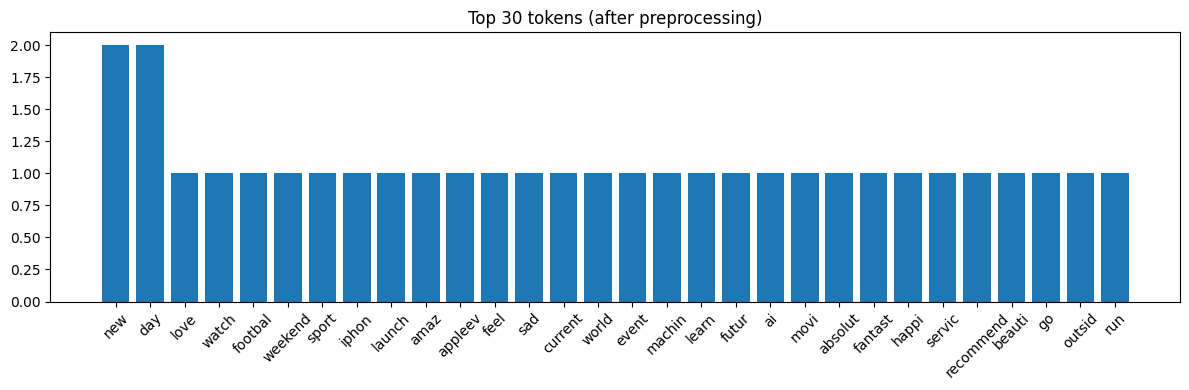

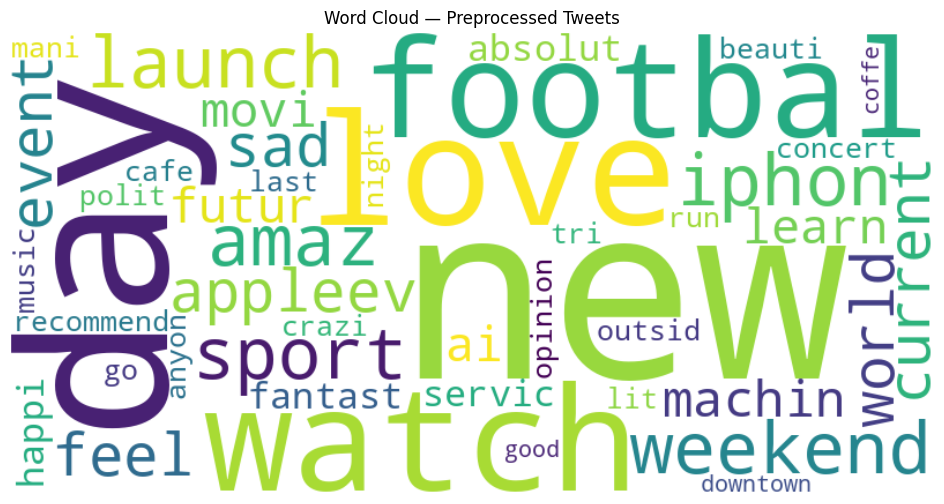

Saved tweets_cleaned.csv with columns: ['text', 'clean_text', 'tokens']


In [18]:

if 'df' in globals() and df is not None:
    all_tokens = [t for tokens in df['tokens'] for t in tokens]
    token_counts = Counter(all_tokens)
    most_common = token_counts.most_common(30)
    print('Top 30 tokens:')
    print(most_common)

    # Bar plot of top 30
    words, counts = zip(*most_common)
    plt.figure(figsize=(12,4))
    plt.bar(words, counts)
    plt.title('Top 30 tokens (after preprocessing)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Word Cloud
    wc = WordCloud(width=800, height=400, background_color='white').generate(" ".join(all_tokens))
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud — Preprocessed Tweets')
    plt.show()

    # Save cleaned CSV for downstream experiments
    df.to_csv('tweets_cleaned.csv', index=False)
    print('Saved tweets_cleaned.csv with columns:', df.columns.tolist())
else:
    print('No data frame loaded. Upload tweets.csv or create sample_tweets.csv using earlier cell.')


### Zipf's Law — log-log rank vs frequency plot and exponent estimation

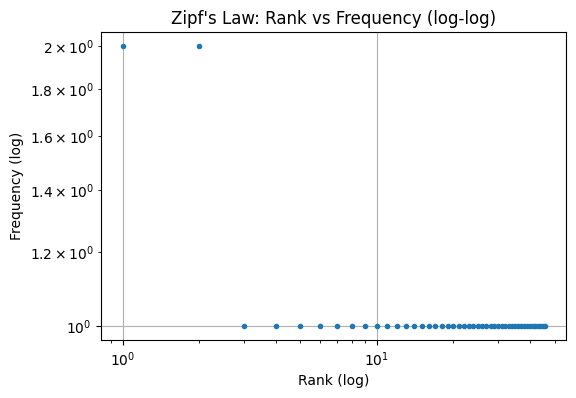

Estimated Zipf slope (approx): -0.10039840319819736
Interpretation: slope ~ -1 indicates typical natural-language behavior.


In [19]:

if 'df' in globals() and df is not None:
    freq_sorted = np.array(sorted(token_counts.values(), reverse=True))
    ranks = np.arange(1, len(freq_sorted)+1)
    plt.figure(figsize=(6,4))
    plt.loglog(ranks, freq_sorted, marker='.', linewidth=0)
    plt.title("Zipf's Law: Rank vs Frequency (log-log)")
    plt.xlabel('Rank (log)')
    plt.ylabel('Frequency (log)')
    plt.grid(True)
    plt.show()

    # Estimate slope using linear fit on log-log (avoid zeros)
    mask = freq_sorted > 0
    coeffs = np.polyfit(np.log(ranks[mask]), np.log(freq_sorted[mask]), 1)
    slope = coeffs[0]
    intercept = coeffs[1]
    print('Estimated Zipf slope (approx):', slope)
    print('Interpretation: slope ~ -1 indicates typical natural-language behavior.')
else:
    print('No data loaded.')


### Heaps' Law — Vocabulary growth vs tokens and exponent estimation

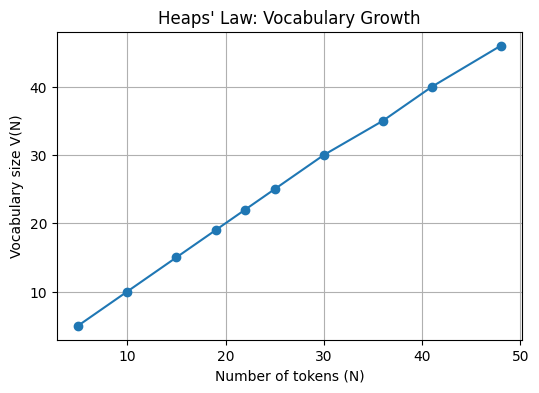

Estimated Heaps exponent (beta): 0.984494079097883
Heaps beta typically between 0.4 and 0.6 for English corpora.


In [20]:

if 'df' in globals() and df is not None:
    vocab_sizes = []
    N_words = []
    vocab = set()
    count = 0
    for tokens in df['tokens']:
        for t in tokens:
            count += 1
            vocab.add(t)
        N_words.append(count)
        vocab_sizes.append(len(vocab))
    plt.figure(figsize=(6,4))
    plt.plot(N_words, vocab_sizes, marker='o')
    plt.title("Heaps' Law: Vocabulary Growth")
    plt.xlabel('Number of tokens (N)')
    plt.ylabel('Vocabulary size V(N)')
    plt.grid(True)
    plt.show()

    # Fit log-log to estimate beta
    mask = np.array(N_words) > 0
    coeffs_h = np.polyfit(np.log(np.array(N_words)[mask]), np.log(np.array(vocab_sizes)[mask]), 1)
    beta = coeffs_h[0]
    print('Estimated Heaps exponent (beta):', beta)
    print('Heaps beta typically between 0.4 and 0.6 for English corpora.')
else:
    print('No data loaded.')


### Topic Modeling using LDA (sklearn) — display top words per topic

In [21]:

if 'df' in globals() and df is not None:
    # For short documents like tweets, increase min_df or aggregate if necessary.
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    dtm = vectorizer.fit_transform(df['clean_text'])
    n_topics = 4
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, learning_method='batch')
    lda.fit(dtm)

    def display_topics(model, feature_names, no_top_words=10):
        topics = []
        for topic_idx, topic in enumerate(model.components_):
            top_features_ind = topic.argsort()[:-no_top_words - 1:-1]
            top_features = [feature_names[i] for i in top_features_ind]
            topics.append(top_features)
            print(f"Topic {topic_idx}:", ', '.join(top_features))
        return topics

    tf_feature_names = vectorizer.get_feature_names_out()
    topics = display_topics(lda, tf_feature_names, no_top_words=12)
else:
    print('No data loaded.')


Topic 0: new, day
Topic 1: new, day
Topic 2: day, new
Topic 3: new, day



### Notes on Topic Modeling Short Texts
- Tweets are short; LDA may produce less coherent topics. Consider:
  - Aggregating tweets by user, day, or hashtag before LDA.
  - Using bigger `min_df` to ignore extremely rare terms.
  - Using alternative models (Biterm Topic Model, BERTopic, or embeddings + clustering).
- Inspect topic keywords and sample tweets closest to each topic to interpret results.


### Save Notebook Outputs & Download cleaned CSV

In [22]:

# Save cleaned CSV (already saved in earlier cell), and list files for download in Colab
if 'df' in globals() and df is not None:
    print('Files available in the working directory:')
    !ls -lh
    print('\nYou can download the cleaned CSV using: files.download("tweets_cleaned.csv") in Colab.')
else:
    print('No processed dataframe to save. If you created sample_tweets.csv earlier, it exists in the working directory.')


Files available in the working directory:
total 20K
drwxr-xr-x 1 root root 4.0K Sep  5 13:36  sample_data
-rw-r--r-- 1 root root  473 Sep  9 13:21  sample_tweets.csv
-rw-r--r-- 1 root root  504 Sep  9 13:21 'tweets (1).csv'
-rw-r--r-- 1 root root 1.3K Sep  9 13:21  tweets_cleaned.csv
-rw-r--r-- 1 root root  504 Sep  9 13:19  tweets.csv

You can download the cleaned CSV using: files.download("tweets_cleaned.csv") in Colab.


In [23]:
files.download("tweets_cleaned.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>